In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# =============================================================================
# DATA LOADING AND EXPLORATION
# =============================================================================

def load_exoplanet_data():
    """Load exoplanet data from NASA Exoplanet Archive"""
    print("\n📡 Loading NASA Exoplanet Archive data...")

    # NASA Exoplanet Archive URL for Planetary Systems Composite Table
    url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,pl_rade,pl_masse,pl_orbper,pl_orbsmax,st_mass,st_rad,st_teff,sy_dist+from+ps+where+pl_rade+is+not+null+and+st_mass+is+not+null+and+st_rad+is+not+null+and+pl_orbper+is+not+null&format=csv"

    df = pd.read_csv(url)
    return df

def explore_dataset(df):
    """Explore the dataset structure and basic statistics"""
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    print(df.describe())

    print("\n❓ Missing Values:")
    print(df.isnull().sum())

    return df


In [3]:

# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================

def preprocess_data(df):
    """Clean and preprocess the data"""

    # Remove rows with missing values in key columns
    key_columns = [col for col in df.columns]

    df_clean = df.copy()
    df_clean[key_columns] = df_clean[key_columns].fillna(df_clean[key_columns].mean())

    print(f"Records after removing missing values: {len(df_clean)}")

    # Remove outliers using IQR method
    def remove_outliers(df, column, factor=3):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Remove outliers from key columns
    for col in key_columns: df_clean = remove_outliers(df_clean, col)

    print(f"Records after removing outliers: {len(df_clean)}")

    return df_clean

def prepare_features(df):
    """Prepare features for machine learning"""

    # Define potential features
    feature_columns = [col for col in df.columns if col != 'pl_rade']

    # Check which features are available and have valid data
    available_features = []
    for col in feature_columns:
        if col in df.columns:
            # Check if column has valid values (not all NaN)
            if not df[col].isna().all():
                available_features.append(col)

    print(f"Available features: {available_features}")

    # Create feature matrix
    X = df[available_features].copy()
    y = df['pl_rade'].copy()

    # Final check - remove any remaining NaN values
    # Create a combined dataframe to ensure we remove rows consistently
    combined_df = pd.concat([X, y], axis=1)
    combined_df = combined_df.dropna()

    # Split back into features and target
    X = combined_df[available_features]
    y = combined_df['pl_rade']

    print(f"Final feature matrix shape: {X.shape}")
    print(f"Final target vector shape: {y.shape}")

    return X, y, available_features


In [4]:
!pip install scikeras

In [5]:

# =============================================================================
# 4. MACHINE LEARNING MODELS
# =============================================================================

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import tensorflow


def train_models(X, y):
    """Train and tune multiple machine learning models"""

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale data for linear models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define hyperparameter grids
    param_grids = {
        'Ridge': {
            'alpha': [100.0]
        },
        'Random Forest': {
            'n_estimators': [500],
            'max_depth': [None],
        },
        'XGBoost': {
            'n_estimators': [1000],
            'max_depth': [6],
        }

    }

    models = {
        'Ridge': Ridge(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    }

    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\n🔧 Tuning and training {name}...")

        # Use scaled data for Ridge, unscaled for trees
        if name == 'Ridge':
            grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
            y_pred = best_model.predict(X_test_scaled)
        elif name in ['Random Forest', 'XGBoost']:
            grid = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            y_pred = best_model.predict(X_test)


        # Metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'Best Params': grid.best_params_ if name != 'DNN' else search.best_params_,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Model': best_model
        }

        predictions[name] = y_pred

        print(f"✅ Best Parameters: {grid.best_params_}")
        print(f"📊 RMSE: {rmse:.3f} | MAE: {mae:.3f} | R²: {r2:.3f}")



    return results, predictions, y_test, X_test, scaler


def get_feature_importance(models, feature_names):
    """Extract feature importance from trained models"""

    importance_data = {}

    for name, model_info in models.items():
        model = model_info['Model']

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_data[name] = dict(zip(feature_names, importances))

            print(f"\n{name} - Top 5 Features:")
            sorted_features = sorted(zip(feature_names, importances),
                                   key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_features[:5]:
                print(f"  {feature}: {importance:.3f}")

    return importance_data


In [6]:
print("Exoplanet Radius Prediction Analysis:")
df = load_exoplanet_data()
df = explore_dataset(df)
df.head()

Exoplanet Radius Prediction Analysis:

📡 Loading NASA Exoplanet Archive data...
Shape: (21478, 10)
Columns: ['pl_name', 'hostname', 'pl_rade', 'pl_masse', 'pl_orbper', 'pl_orbsmax', 'st_mass', 'st_rad', 'st_teff', 'sy_dist']
            pl_rade      pl_masse     pl_orbper    pl_orbsmax       st_mass  \
count  21478.000000   2765.000000  2.147800e+04  17540.000000  21478.000000   
mean       5.657887    358.164376  1.911821e+04      0.574677      0.936252   
std       80.593464    909.087245  2.743567e+06     56.694724      0.278968   
min        0.270000      0.065000  1.120067e-01      0.005800      0.014700   
25%        1.520000      9.990000  4.417803e+00      0.051000      0.815000   
50%        2.240000    120.000000  9.977189e+00      0.087000      0.947000   
75%        3.140000    360.099585  2.279011e+01      0.156000      1.065000   
max     4282.980000  25426.400000  4.020000e+08   7506.000000     23.560000   

             st_rad       st_teff       sy_dist  
count  21478.

,pl_name,hostname,pl_rade,pl_masse,pl_orbper,pl_orbsmax,st_mass,st_rad,st_teff,sy_dist
0,Kepler-20 d,Kepler-20,2.75000,20.10000,77.611840,0.3453,0.912,0.944,5455.0,282.563
1,Kepler-976 b,Kepler-976,3.81000,NaN,105.956415,0.4209,0.887,0.796,5308.0,1012.410
2,Kepler-61 b,Kepler-61,2.15000,NaN,59.877560,NaN,0.635,0.620,4017.0,335.079
3,Kepler-407 b,Kepler-407,1.21000,NaN,0.669310,0.0152,1.051,1.067,5626.0,338.368
4,WASP-58 b,WASP-58,15.35633,285.72917,5.017180,0.0562,0.940,1.170,5800.0,290.404


In [7]:
df=df.drop(columns=['pl_name','hostname'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21478 entries, 0 to 21477
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pl_rade     21478 non-null  float64
 1   pl_masse    2765 non-null   float64
 2   pl_orbper   21478 non-null  float64
 3   pl_orbsmax  17540 non-null  float64
 4   st_mass     21478 non-null  float64
 5   st_rad      21478 non-null  float64
 6   st_teff     21149 non-null  float64
 7   sy_dist     20962 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21478 entries, 0 to 21477
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pl_rade     21478 non-null  float64
 1   pl_masse    2765 non-null   float64
 2   pl_orbper   21478 non-null  float64
 3   pl_orbsmax  17540 non-null  float64
 4   st_mass     21478 non-null  float64
 5   st_rad      21478 non-null  float64
 6   st_teff     21149 non-null  float64
 7   sy_dist     20962 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [9]:
df = df.drop(columns='pl_masse')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21478 entries, 0 to 21477
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pl_rade     21478 non-null  float64
 1   pl_orbper   21478 non-null  float64
 2   pl_orbsmax  17540 non-null  float64
 3   st_mass     21478 non-null  float64
 4   st_rad      21478 non-null  float64
 5   st_teff     21149 non-null  float64
 6   sy_dist     20962 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [10]:
# Preprocess data
df_clean = preprocess_data(df)
df_clean.dropna(inplace=True)
df_clean.head()

Records after removing missing values: 21478
Records after removing outliers: 17637


,pl_rade,pl_orbper,pl_orbsmax,st_mass,st_rad,st_teff,sy_dist
0,2.750,77.611840,0.345300,0.912,0.944,5455.0,282.563
2,2.150,59.877560,0.574677,0.635,0.620,4017.0,335.079
3,1.210,0.669310,0.015200,1.051,1.067,5626.0,338.368
5,3.000,40.109990,0.231000,1.024,0.930,5966.0,1165.340
6,1.268,5.433122,0.057530,0.860,0.787,5106.0,527.321


In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17637 entries, 0 to 21477
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pl_rade     17637 non-null  float64
 1   pl_orbper   17637 non-null  float64
 2   pl_orbsmax  17637 non-null  float64
 3   st_mass     17637 non-null  float64
 4   st_rad      17637 non-null  float64
 5   st_teff     17637 non-null  float64
 6   sy_dist     17637 non-null  float64
dtypes: float64(7)
memory usage: 1.1 MB


In [12]:
X, y, features = prepare_features(df_clean)


Available features: ['pl_orbper', 'pl_orbsmax', 'st_mass', 'st_rad', 'st_teff', 'sy_dist']
Final feature matrix shape: (17637, 6)
Final target vector shape: (17637,)


In [13]:
# Train models
model_results, predictions, y_test, X_test, scaler = train_models(X, y)


🔧 Tuning and training Ridge...
✅ Best Parameters: {'alpha': 100.0}
📊 RMSE: 1.024 | MAE: 0.733 | R²: 0.107

🔧 Tuning and training Random Forest...
✅ Best Parameters: {'max_depth': None, 'n_estimators': 500}
📊 RMSE: 0.610 | MAE: 0.326 | R²: 0.684

🔧 Tuning and training XGBoost...
✅ Best Parameters: {'max_depth': 6, 'n_estimators': 1000}
📊 RMSE: 0.579 | MAE: 0.290 | R²: 0.714


In [14]:
#model_results

In [15]:
# Get feature importance
importance_data = get_feature_importance(model_results, features)



Random Forest - Top 5 Features:
  pl_orbper: 0.287
  sy_dist: 0.243
  st_teff: 0.147
  st_rad: 0.141
  st_mass: 0.111

XGBoost - Top 5 Features:
  sy_dist: 0.261
  pl_orbper: 0.203
  st_teff: 0.173
  st_rad: 0.162
  st_mass: 0.132


In [21]:

# =============================================================================
# 5. VISUALIZATION
# =============================================================================

def create_visualizations(df, model_results, predictions,
                         y_test, importance_data, features):
    """Create comprehensive visualizations with individual plots"""

    # Set style for better looking plots
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 20
    })

    best_model = max(model_results.keys(), key=lambda x: model_results[x]['R²'])
    y_pred_best = predictions[best_model]


    # 2. Enhanced Target Distribution with Statistics
    plt.figure(figsize=(12, 8))
    n_bins = 50
    counts, bins, patches = plt.hist(df['pl_rade'], bins=n_bins, alpha=0.7,
                                    color='skyblue', edgecolor='black', linewidth=1)

    # Add statistics text
    mean_val = df['pl_rade'].mean()
    median_val = df['pl_rade'].median()
    std_val = df['pl_rade'].std()

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.xlabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.title('Distribution of Planet Radii', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add text box with statistics
    stats_text = f'Statistics:\nMean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}\nCount: {len(df)}'
    plt.text(0.7, 0.8, stats_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

    # 3. Enhanced Scatter Plot with Regression Line
    plt.figure(figsize=(12, 8))
    plt.scatter(df['st_mass'], df['pl_rade'], alpha=0.6, s=60,
                c=df['st_teff'], cmap='viridis', edgecolors='black', linewidth=0.5)

    # Add regression line
    z = np.polyfit(df['st_mass'], df['pl_rade'], 1)
    p = np.poly1d(z)
    plt.plot(df['st_mass'], p(df['st_mass']), "r--", alpha=0.8, linewidth=2)

    plt.xlabel('Stellar Mass (Solar Masses)', fontsize=16)
    plt.ylabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.title('Planet Radius vs Stellar Mass\n(Colored by Stellar Temperature)', fontsize=20, fontweight='bold', pad=20)

    cbar = plt.colorbar(label='Stellar Temperature (K)')
    cbar.ax.tick_params(labelsize=12)

    # Add correlation coefficient
    corr_coef = np.corrcoef(df['st_mass'], df['pl_rade'])[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Enhanced Model Performance Comparison
    plt.figure(figsize=(12, 8))
    model_names = list(model_results.keys())
    r2_scores = [model_results[name]['R²'] for name in model_names]
    rmse_scores = [model_results[name]['RMSE'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # R² scores
    bars1 = ax1.bar(x, r2_scores, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                   alpha=0.8, edgecolor='black')
    ax1.set_ylabel('R² Score', fontsize=16)
    ax1.set_title('Model Performance - R² Score', fontsize=18, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars1, r2_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # RMSE scores
    bars2 = ax2.bar(x, rmse_scores, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                   alpha=0.8, edgecolor='black')
    ax2.set_ylabel('RMSE (Earth Radii)', fontsize=16)
    ax2.set_title('Model Performance - RMSE', fontsize=18, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars2, rmse_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 5. Enhanced Actual vs Predicted
    plt.figure(figsize=(12, 10))
    plt.scatter(y_test, y_pred_best, alpha=0.6, s=80,
                c=np.abs(y_test - y_pred_best), cmap='viridis_r',
                edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred_best.min())
    max_val = max(y_test.max(), y_pred_best.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, alpha=0.8, label='y=x')

    # Confidence intervals
    plt.fill_between([min_val, max_val], [min_val * 0.8, max_val * 0.8],
                     [min_val * 1.2, max_val * 1.2], alpha=0.2, color='gray', label='±20% Error')

    plt.xlabel('Actual Planet Radius (Earth Radii)', fontsize=16)
    plt.ylabel('Predicted Planet Radius (Earth Radii)', fontsize=16)
    plt.title(f'Actual vs Predicted Planet Radius\n({best_model})', fontsize=20, fontweight='bold', pad=20)

    cbar = plt.colorbar(label='Prediction Error (Earth Radii)')
    cbar.ax.tick_params(labelsize=12)

    # Add metrics
    r2_best = model_results[best_model]['R²']
    rmse_best = model_results[best_model]['RMSE']
    mae_best = model_results[best_model]['MAE']

    metrics_text = f'Metrics:\nR² = {r2_best:.3f}\nRMSE = {rmse_best:.3f}\nMAE = {mae_best:.3f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold', verticalalignment='top')

    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 6. Enhanced Feature Importance
    plt.figure(figsize=(12, 8))
    if 'XGBoost' in importance_data:
        rf_importance = importance_data['XGBoost']
        sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)
        feature_names = [item[0] for item in sorted_features]
        importance_values = [item[1] for item in sorted_features]

        colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))
        bars = plt.barh(range(len(feature_names)), importance_values, color=colors, alpha=0.8,
                       edgecolor='black')

        plt.yticks(range(len(feature_names)), feature_names, fontsize=14)
        plt.xlabel('Feature Importance', fontsize=16)
        plt.title('Feature Importance Analysis\n(XGBoost)', fontsize=20, fontweight='bold', pad=20)
        plt.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for i, (bar, importance) in enumerate(zip(bars, importance_values)):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{importance:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 7. Enhanced Orbital Period Analysis
    plt.figure(figsize=(12, 8))
    plt.scatter(df['pl_orbper'], df['pl_rade'], alpha=0.6, s=60,
                c=df['st_mass'], cmap='plasma', edgecolors='black', linewidth=0.5)

    plt.xlabel('Orbital Period (Days)', fontsize=16)
    plt.ylabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.title('Planet Radius vs Orbital Period\n(Colored by Stellar Mass)', fontsize=20, fontweight='bold', pad=20)
    plt.xscale('log')

    cbar = plt.colorbar(label='Stellar Mass (Solar Masses)')
    cbar.ax.tick_params(labelsize=12)

    # Add correlation
    corr_coef = np.corrcoef(np.log10(df['pl_orbper']), df['pl_rade'])[0, 1]
    plt.text(0.05, 0.95, f'Log Correlation: {corr_coef:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 8. Enhanced Stellar Temperature Analysis
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['st_teff'], df['pl_rade'], alpha=0.6, s=60,
                         c=df['st_rad'], cmap='coolwarm', edgecolors='black', linewidth=0.5)

    plt.xlabel('Stellar Temperature (K)', fontsize=16)
    plt.ylabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.title('Planet Radius vs Stellar Temperature\n(Colored by Stellar Radius)', fontsize=20, fontweight='bold', pad=20)

    cbar = plt.colorbar(scatter, label='Stellar Radius (Solar Radii)')
    cbar.ax.tick_params(labelsize=12)

    # Add correlation
    corr_coef = np.corrcoef(df['st_teff'], df['pl_rade'])[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    return best_model

# =============================================================================
# 6. RESULTS INTERPRETATION
# =============================================================================

def interpret_results(model_results, best_model, importance_data):
    """Interpret and summarize the results"""
    print("\n🎯 Results Interpretation")
    print("=" * 50)

    print(f"\n🏆 Best Performing Model: {best_model}")
    print(f"R² Score: {model_results[best_model]['R²']:.3f}")
    print(f"RMSE: {model_results[best_model]['RMSE']:.3f} Earth Radii")
    print(f"MAE: {model_results[best_model]['MAE']:.3f} Earth Radii")

    print("\n📊 Key Findings:")
    print("1. MODEL PERFORMANCE:")
    for name, results in model_results.items():
        print(f"   • {name}: R² = {results['R²']:.3f}, RMSE = {results['RMSE']:.3f}")

    print("\n2. MOST IMPORTANT FEATURES:")
    if importance_data:
        rf_importance = importance_data.get('Random Forest', {})
        if rf_importance:
            sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)
            for i, (feature, importance) in enumerate(sorted_features[:5]):
                print(f"   • {feature}: {importance:.3f}")


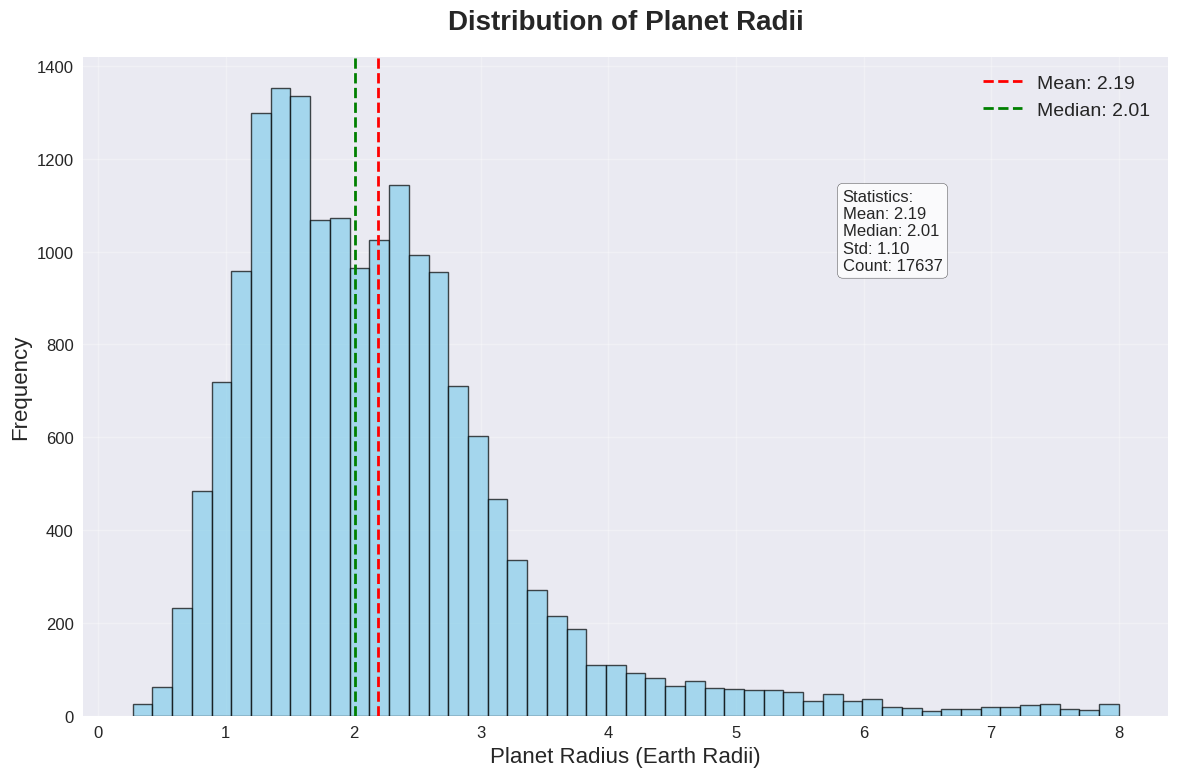

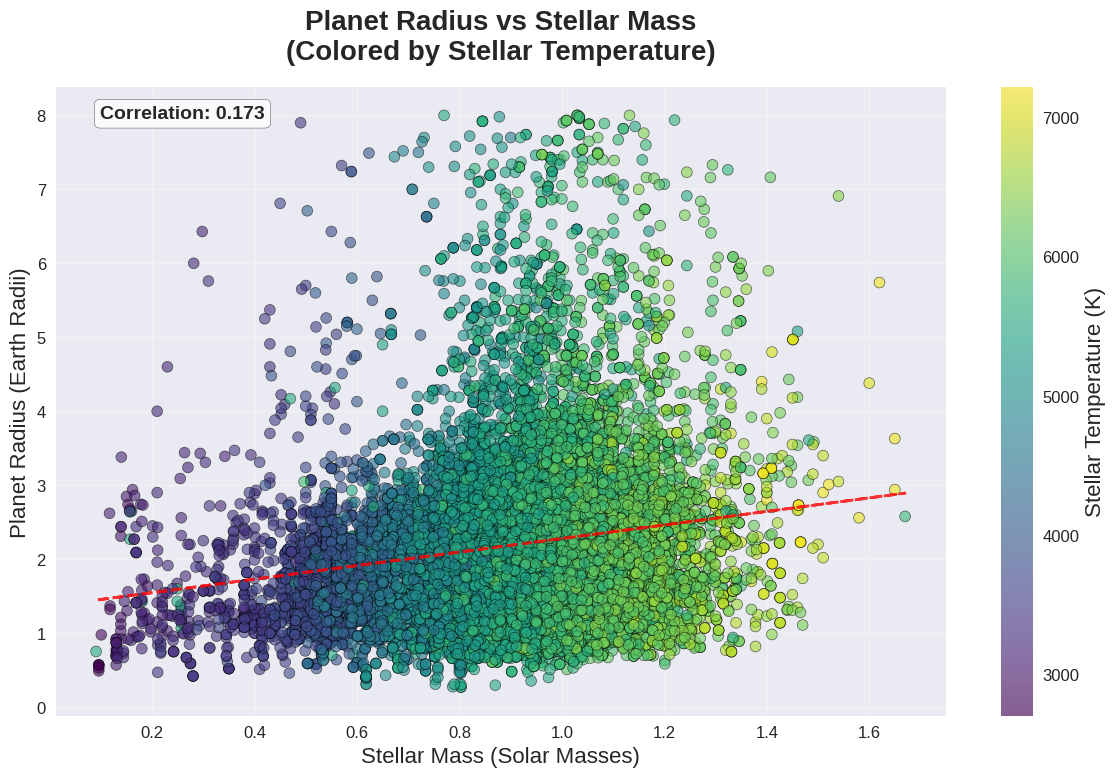

<Figure size 1200x800 with 0 Axes>

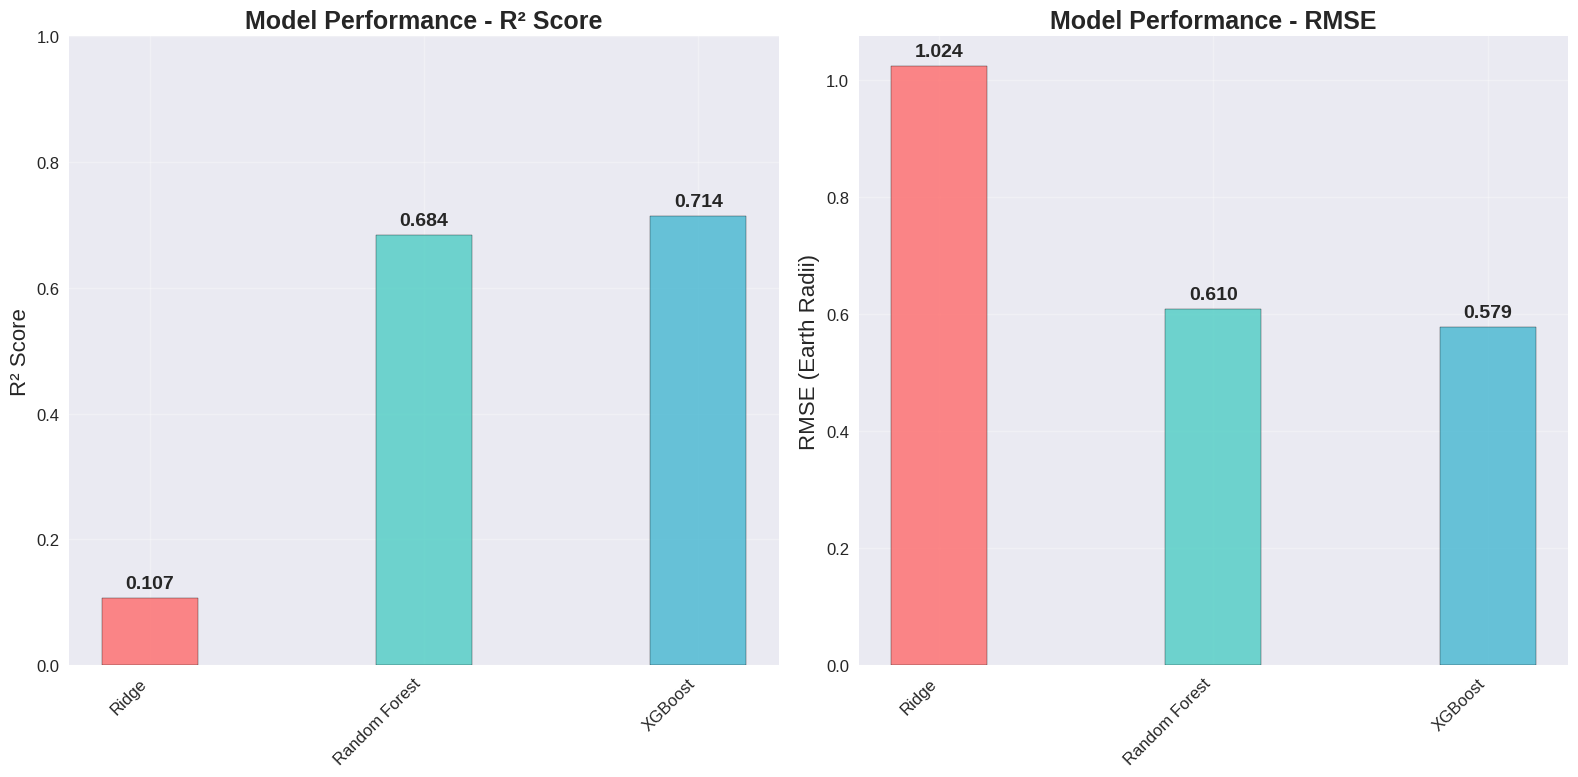

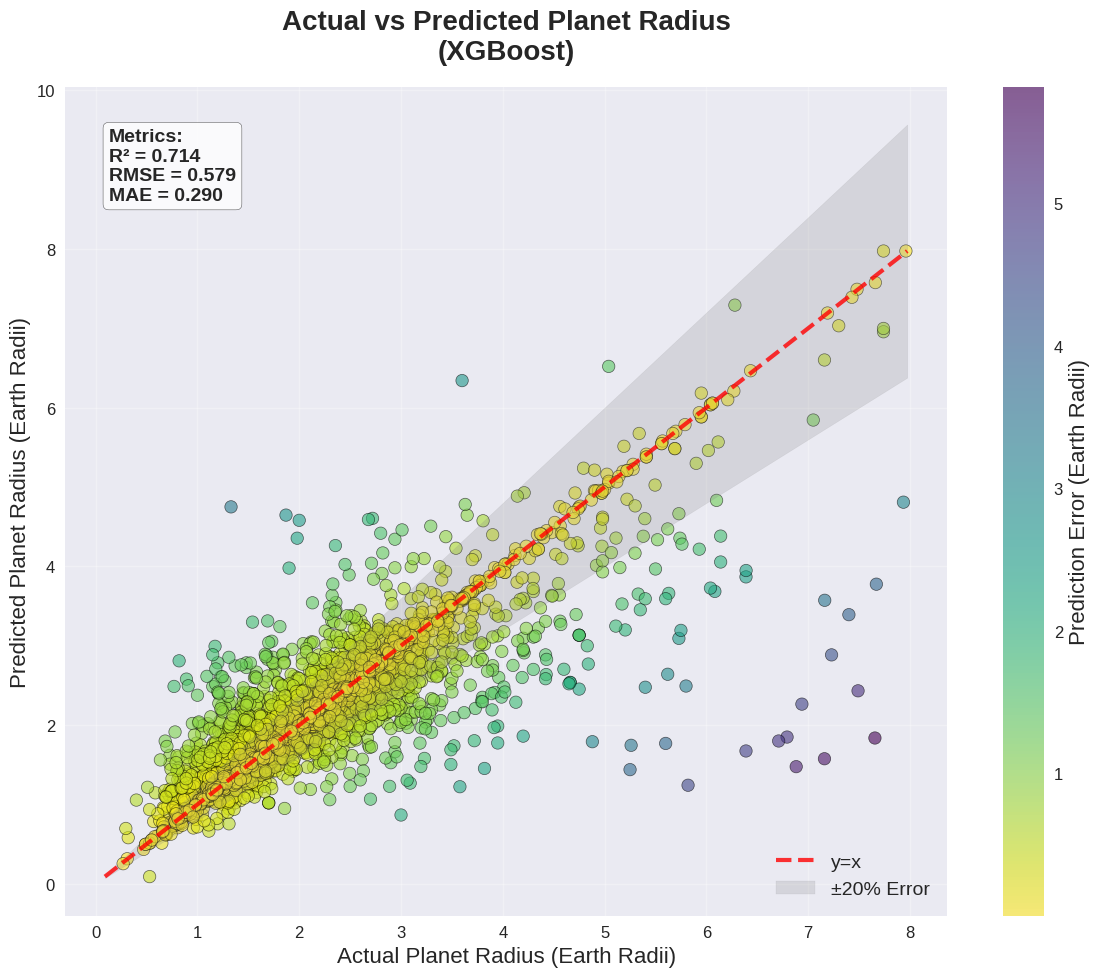

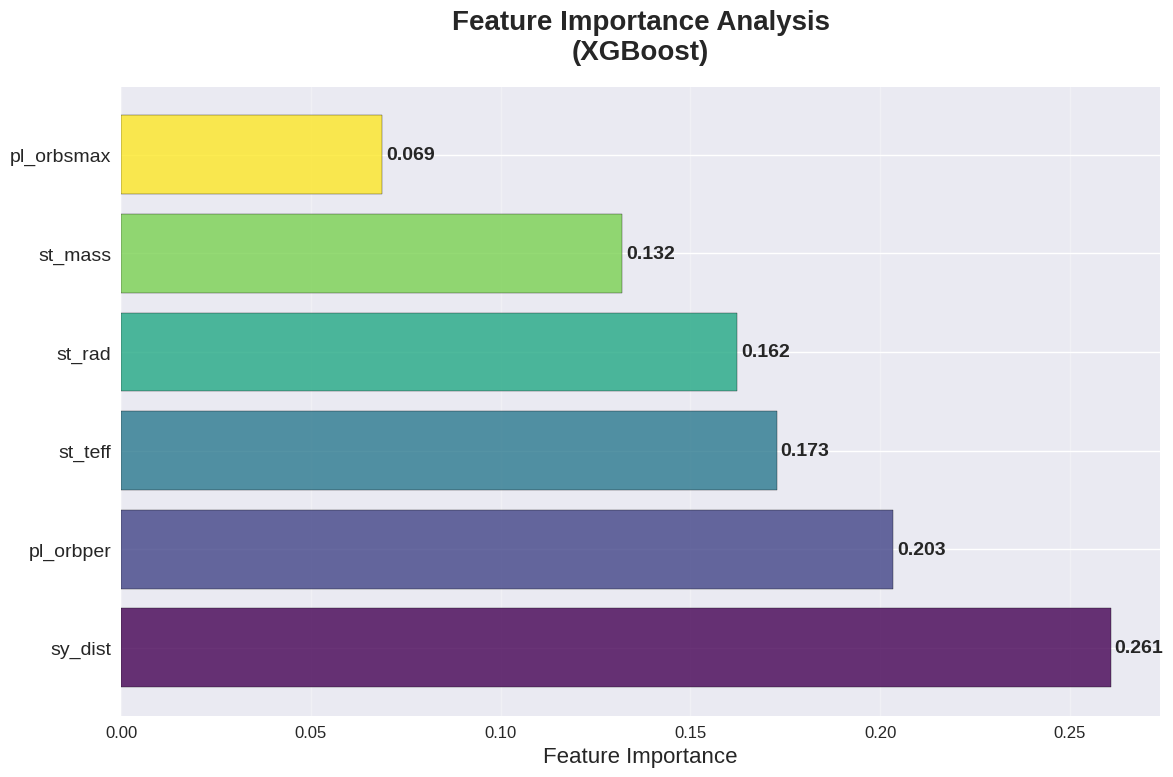

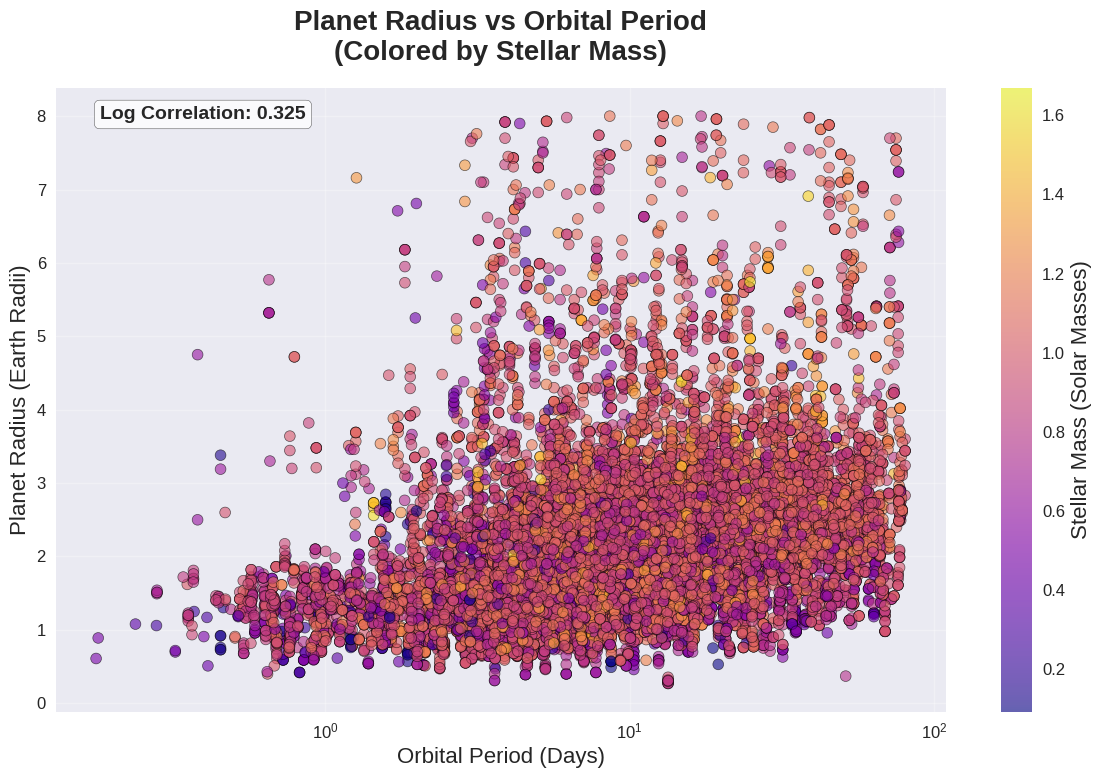

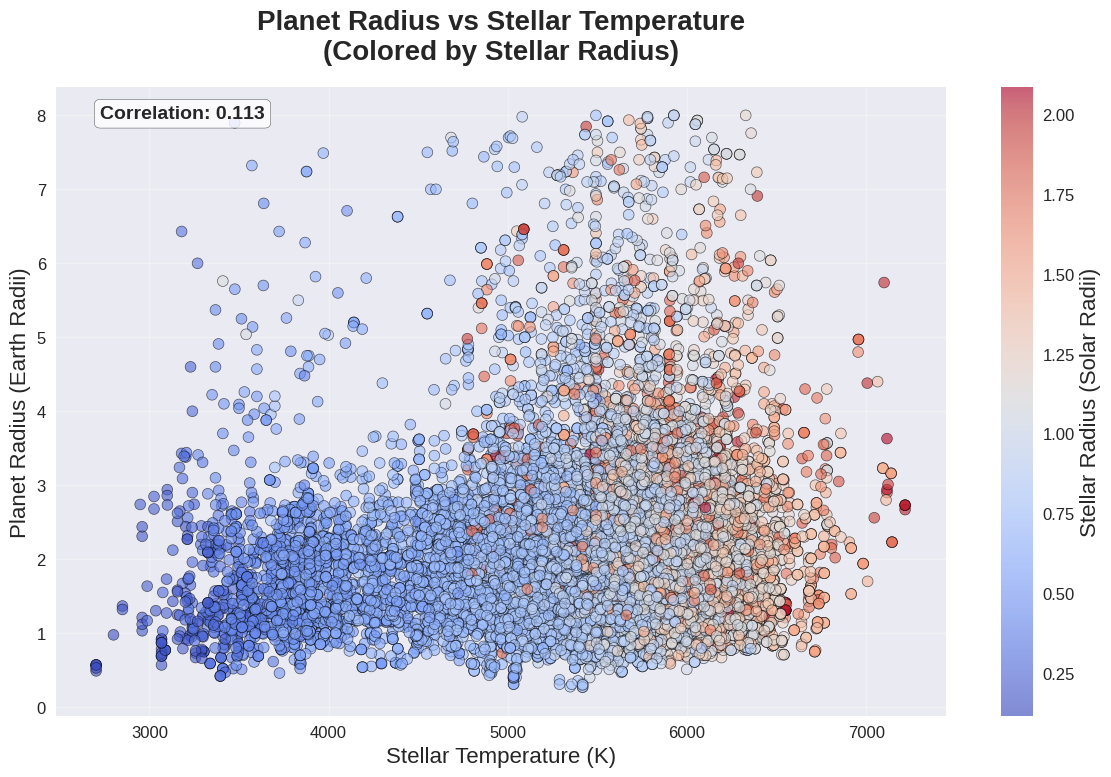

In [22]:
# Create visualizations
best_model = create_visualizations(df_clean,  model_results,
                                     predictions, y_test, importance_data, features)

In [20]:
# Interpret results
interpret_results(model_results, best_model, importance_data)



🎯 Results Interpretation

🏆 Best Performing Model: XGBoost
R² Score: 0.714
RMSE: 0.579 Earth Radii
MAE: 0.290 Earth Radii

📊 Key Findings:
1. MODEL PERFORMANCE:
   • Ridge: R² = 0.107, RMSE = 1.024
   • Random Forest: R² = 0.684, RMSE = 0.610
   • XGBoost: R² = 0.714, RMSE = 0.579

2. MOST IMPORTANT FEATURES:
   • pl_orbper: 0.287
   • sy_dist: 0.243
   • st_teff: 0.147
   • st_rad: 0.141
   • st_mass: 0.111
